Using device: cuda


C:\Users\raghu\AppData\Local\Temp\ipykernel_12008\2549332448.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean().reset_index()


{
    "sequence_key": "sequence_id",
    "columns": {
        "timestamp": {
            "sdtype": "datetime"
        },
        "sensor_id": {
            "sdtype": "categorical"
        },
        "reading": {
            "sdtype": "numerical"
        },
        "sequence_id": {
            "sdtype": "id"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}


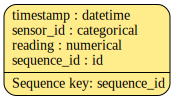

In [2]:
import pandas as pd
from sdv.metadata import SingleTableMetadata
from sdv.sequential import PARSynthesizer
import torch
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed
import pickle

# Clear GPU cache
torch.cuda.empty_cache()

# Garbage collection to free up memory
gc.collect()

# Verify if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Load your data from a CSV file (replace this with the actual path to your CSV file)
df = pd.read_csv('C:/Users/raghu/CS6140/PEMS-BAY.csv')

# Convert the datetime column and handle parsing errors
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'], errors='coerce')

# Remove rows with invalid datetime values
df = df.dropna(subset=['Unnamed: 0'])

# Rename the datetime column
df.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)

# Set the timestamp column as the index
df.set_index('timestamp', inplace=True)

# Aggregate data to hourly intervals by computing the mean for each hour
df_hourly = df.resample('H').mean().reset_index()

# Melt the dataframe to have a long format
data_long = df_hourly.melt(id_vars=['timestamp'], var_name='sensor_id', value_name='reading')

# Sort the DataFrame by 'timestamp'
data_long = data_long.sort_values(by='timestamp')

# Create a combined sequence ID based on the timestamp and sensor_id
data_long['sequence_id'] = data_long['timestamp'].astype(str) + '_' + data_long['sensor_id'].astype(str)

# Define metadata
metadata = SingleTableMetadata()

# Add the columns to the metadata
metadata.add_column('timestamp', sdtype='datetime')
metadata.add_column('sensor_id', sdtype='categorical')
metadata.add_column('reading', sdtype='numerical')
metadata.add_column('sequence_id', sdtype='id')

# Set the sequence key in the metadata
metadata.set_sequence_key('sequence_id')
print(metadata)
# Visualize the metadata
metadata.visualize()

In [ ]:
# Initialize the PARSynthesizer with CUDA
synthesizer = PARSynthesizer(
    metadata=metadata,
    verbose=True,
    cuda=True  # Use GPU
)

# Define sequence length
sequence_length = 24  # 24 hourly intervals in a day

# Fit the synthesizer to the data in segments to manage memory usage
num_segments = 20  # Increase the number of segments to further reduce memory usage per segment
segment_length = len(data_long) // num_segments

def process_segment(i):
    start_idx = i * segment_length
    end_idx = start_idx + segment_length if i < num_segments - 1 else len(data_long)
    data_segment = data_long.iloc[start_idx:end_idx]
    
    print(f"Fitting segment {i+1}/{num_segments}, rows {start_idx} to {end_idx}")
    
    synthesizer.fit(data_segment)
    torch.cuda.empty_cache()
    gc.collect()
    
    # Save the synthetic data segment to a CSV file
    synthetic_data_segment = synthesizer.sample(num_sequences=len(data_segment['sequence_id'].unique()), sequence_length=sequence_length)
    synthetic_data_segment.to_csv(f'synthetic_data_segment_{i+1}.csv', index=False)

# Fit the synthesizer using threading
with ThreadPoolExecutor(max_workers=3) as executor:  # Adjust max_workers as needed
    futures = [executor.submit(process_segment, i) for i in range(num_segments)]
    for future in as_completed(futures):
        future.result()  # Wait for all futures to complete

# Load and merge all synthetic data segments into a single DataFrame
synthetic_data_all_segments = pd.concat(
    [pd.read_csv(f'synthetic_data_segment_{i+1}.csv') for i in range(num_segments)],
    ignore_index=True
)

# Save the merged synthetic data to a single CSV file
synthetic_data_all_segments.to_csv('synthetic_data_merged.csv', index=False)

# Print the merged synthetic data
print(synthetic_data_all_segments)

Using device: cuda
0           2017-01-01
1           2017-01-01
2           2017-01-01
3           2017-01-01
4           2017-01-01
               ...    
16937695    2017-06-30
16937696    2017-06-30
16937697    2017-06-30
16937698    2017-06-30
16937699    2017-06-30
Name: sequence_id, Length: 16937700, dtype: object


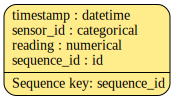

In [1]:
import pandas as pd
from sdv.metadata import SingleTableMetadata
from sdv.sequential import PARSynthesizer
import torch
import gc
import pickle
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

# Clear GPU cache
torch.cuda.empty_cache()

# Garbage collection to free up memory
gc.collect()

# Verify if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load your data from a CSV file (replace this with the actual path to your CSV file)
df = pd.read_csv('C:/Users/raghu/CS6140/PEMS-BAY.csv')

# Convert the datetime column and handle parsing errors
def parse_dates(x):
    try:
        return pd.to_datetime(x)
    except:
        return pd.NaT

df['Unnamed: 0'] = df['Unnamed: 0'].apply(parse_dates)

# Remove rows with invalid datetime values
df = df.dropna(subset=['Unnamed: 0'])

# Rename the datetime column
df.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)

# Melt the dataframe to have a long format
data_long = df.melt(id_vars=['timestamp'], var_name='sensor_id', value_name='reading')

data_long['sequence_id'] = data_long['timestamp'].dt.date

print(data_long['sequence_id'])
# Define metadata
metadata = SingleTableMetadata()

# Add the columns to the metadata
metadata.add_column('timestamp', sdtype='datetime')
metadata.add_column('sensor_id', sdtype='categorical')
metadata.add_column('reading', sdtype='numerical')
metadata.add_column('sequence_id', sdtype='id')

# Set the sequence key in the metadata
metadata.set_sequence_key('sequence_id')

# Visualize the metadata
metadata.visualize()

In [ ]:
# Define sequence length
sequence_length = 288  # Adjust this value as needed

# Fit the synthesizer to the data in segments to manage memory usage
num_segments = 20  # Increase the number of segments to further reduce memory usage per segment
segment_length = len(data_long) // num_segments

def process_segment(i):
    # Initialize a new synthesizer for each thread
    synthesizer = PARSynthesizer(
        metadata=metadata,
        verbose=True,
        cuda=True  # Use GPU
    )
    
    start_idx = i * segment_length
    end_idx = start_idx + segment_length if i < num_segments - 1 else len(data_long)
    data_segment = data_long.iloc[start_idx:end_idx]
    
    print(f"Fitting segment {i+1}/{num_segments}, rows {start_idx} to {end_idx}")
    
    synthesizer.fit(data_segment)
    torch.cuda.empty_cache()
    gc.collect()
    
    # Generate and save synthetic data after processing each segment
    synthetic_data = synthesizer.sample(num_sequences=len(data_long['sequence_id'].unique()), sequence_length=sequence_length)
    synthetic_data.to_csv(f'synthetic_data_segment_{i+1}.csv', index=False)
    
    # Print progress for every 5% of segments completed
    if (i + 1) % (num_segments // 20) == 0:
        print(f"Progress: {((i + 1) / num_segments) * 100:.2f}%")

with ThreadPoolExecutor(max_workers=2) as executor:  # Adjust max_workers as needed
    futures = [executor.submit(process_segment, i) for i in range(num_segments)]
    for future in as_completed(futures):
        future.result()  # Wait for all futures to complete

# Generate final synthetic data after all segments are processed
synthesizer = PARSynthesizer(
    metadata=metadata,
    verbose=True,
    cuda=True  # Use GPU
)

# Fit the synthesizer to the data again for consolidation (if needed)
synthesizer.fit(data_long)

synthetic_data = synthesizer.sample(num_sequences=len(data_long['sequence_id'].unique()), sequence_length=sequence_length)

# Output the final synthetic data
print(synthetic_data)

# Save the final synthetic data to a CSV file
synthetic_data.to_csv('synthetic_data_final.csv', index=False)

In [ ]:
synthetic_data_all_segments = pd.concat(
    [pd.read_csv(f'synthetic_data_segment_{i+1}.csv') for i in range(num_segments)],
    ignore_index=True
)

# Save the merged synthetic data to a single CSV file
synthetic_data_all_segments.to_csv('synthetic_data_merged.csv', index=False)

# Print the merged synthetic data
print(synthetic_data_all_segments)